# **Paper 1: Regularization Effectiveness Study**  
### *Does Regularization Materially Improve Generalization on the Bike Sharing Dataset?*  

**Authors:**  
Aylin Bozkurt (00161185) and Jana Mumm (00175699)  

**Faculty of Business**  
**Applied Artificial Intelligence and Digital Transformation (KDT)**  
**Ansbach University of Applied Sciences**  

**Course:** Angewandte Künstliche Intelligenz I  
**Professor:** Prof. Dr. Sigurd Schacht  
**Date:** November 2, 2025


# ===========================================
# 1. IMPORTS AND SETUP

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Imports for linear models (OLS, Ridge, Lasso, ElasticNet)
# These cover standard regression models and regularization techniques used in Labs 1 and 3
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV  # Cross-validated versions

# Imports for data splitting, cross-validation, hyperparameter tuning, and learning curves
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve  # For learning curve visualizations
from sklearn.linear_model import lasso_path, enet_path  # To visualize coefficient paths over alpha
from sklearn.preprocessing import StandardScaler  # For feature standardization
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Model evaluation metrics
from sklearn.exceptions import ConvergenceWarning # Warnings module will be used later to suppress ConvergenceWarnings

from scipy import stats  # Statistical tests: paired t-test, Wilcoxon test, etc.

# Display options: show full DataFrame, all columns, and wide output for better readability
pd.set_option('display.max_columns', None)  # Display all columns without truncation
pd.set_option('display.width', None)        # Allow unlimited width (no line wrapping)
pd.set_option('display.max_colwidth', None) # Show full content of each cell

# Set random seed for reproducibility of results
np.random.seed(42)

# Plot settings: consistent style and color palette for all figures
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')  # Husl palette for consistent colors

print("Libraries, setup, and display options successfully initialized.")  # Confirm setup


Libraries, setup, and display options successfully initialized.


# 2. DATA LOADING AND EXPLORATION (EDA)

In [23]:
# ----------------- 2.1 Data Loading -----------------
# The Bike Sharing Dataset, initially compiled by Fanaee-T, H., provides both daily ('day.csv') and hourly ('hour.csv') records.
# We select 'hour.csv' for a detailed time-series regression analysis and to include the 'hr' (hour) feature.

DATA_PATH = "../Data/hour.csv"  # Path to the dataset file

try:
    # Attempt to load the CSV file into a pandas DataFrame
    df = pd.read_csv(DATA_PATH)
    print(f"\nDataset '{DATA_PATH}' successfully loaded. Data shape: {df.shape}")  # Confirm successful load and show dimensions
except FileNotFoundError:
    # Handle case where file cannot be found
    print(f"\nERROR: File '{DATA_PATH}' not found.")
    print("Action required: Please verify the relative path. The file must be located as specified.")  # Guidance for fixing path issues



Dataset '../Data/hour.csv' successfully loaded. Data shape: (17379, 17)


In [24]:
print("\nData overview:")
# Display the first 18 rows to get an initial view of the dataset
display(df.head(18))


Data overview:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


In [25]:
# Print header for clarity in notebook output
print("\nDescriptive Statistics:")

# Generate descriptive statistics for all columns, including numeric, categorical, and datetime features
# This provides a quick overview of distributions, counts, unique values, means, std deviations, etc.
display(df[df.columns].describe(include='all'))  # Display nicely formatted table in the notebook



Descriptive Statistics:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
unique,NaN,731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2012-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,8690.0000,NaN,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,NaN,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,NaN,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,NaN,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,NaN,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,NaN,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000


# 3. DATA PREPROCESSING

In [26]:
# Check the total number of missing values (NaN) in the dataset
total_nan = df.isnull().sum().sum()  # Sum all NaN values across all columns

if total_nan == 0:
    # If no missing values are present, confirm dataset completeness
    print("[OK] No NaN values found in the dataset. All columns are complete.")
else:
    # If there are missing values, report total count
    print(f"! There are {total_nan} NaN values in the dataset!")

    # Count NaN values per individual column
    print("\nNumber of NaN values per column:")
    print(df.isnull().sum())

    # Display only columns that contain at least one NaN value for easier inspection
    print("\nColumns with at least one NaN value:")
    print(df.isnull().any()[df.isnull().any()])


[OK] No NaN values found in the dataset. All columns are complete.


In [27]:
# ----------------- Feature / Target Split -----------------
# Separate dataset into input features (X) and target variable (y) for modeling

# Exclude columns that are not useful as features or could cause leakage
X = df.drop(columns=['instant','dteday','casual','registered','cnt'])  # Feature set

# Explanation of excluded columns:
# - 'instant': sequential index, provides no predictive information
# - 'dteday': raw date; derived features like 'hr', 'weekday', 'mnth' are more informative
# - 'casual' and 'registered': these sum to 'cnt', including them would cause data leakage
# - 'cnt': the target variable itself must not be included as a feature

# Remaining columns (e.g., 'temp', 'atemp', 'hum', 'windspeed', 'season', etc.) are used as input features

# Target variable
y = df['cnt']  # Total bike rentals per hour

# ----------------- Feature / Target Split Overview -----------------
features_list = X.columns.tolist()  # List of feature names
target_list = [y.name]              # Target name as list for display

print("\n[OK] Feature/Target Split Overview:")
print(f"{'Type':<10}     | {'Count':<5} | Columns")
print("-"*50)
print(f"{'Features':<10}     | {X.shape[1]:<5} | {', '.join(features_list)}")  # Show features count and names
print(f"{'Target':<10}     | {1:<5} | {', '.join(target_list)}")               # Show target info



[OK] Feature/Target Split Overview:
Type           | Count | Columns
--------------------------------------------------
Features       | 12    | season, yr, mnth, hr, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed
Target         | 1     | cnt


In [28]:
# ----------------- 3. Identify Categorical and Numerical Features -----------------
# Define categorical features to be one-hot encoded
CATEGORICAL_FEATURES = ['season','weathersit','mnth','hr','weekday','yr','holiday','workingday']

# Define numerical features to be scaled
NUMERICAL_FEATURES = ['temp','atemp','hum','windspeed']

# ====================================================================
# Convert categorical columns to string type
# This ensures that pd.get_dummies correctly encodes them
# ====================================================================
for col in CATEGORICAL_FEATURES:
    X[col] = X[col].astype(str)  # Convert int64 columns to string

# ----------------- 4. One-Hot Encoding for Categorical Features -----------------
# One-hot encode categorical features without dropping any categories
X_cat_encoded = pd.get_dummies(X[CATEGORICAL_FEATURES], drop_first=False)

# Verify that the encoding produced the expected number of columns
print(f" One-Hot Encoding completed: {X_cat_encoded.shape[1]} features created from {len(CATEGORICAL_FEATURES)} categorical columns.")

# ----------------- 5. Feature Scaling for Numerical Features -----------------
# Standardize numerical features (mean=0, std=1)
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X[NUMERICAL_FEATURES]),
    columns=NUMERICAL_FEATURES,
    index=X.index
)
print(" Numerical features scaled (mean=0, std=1) using StandardScaler.")

# ----------------- 6. Combine Processed Features -----------------
# Concatenate scaled numerical features and one-hot encoded categorical features
X_processed = pd.concat([X_num_scaled, X_cat_encoded], axis=1)
print(f"[INFO] Final feature set X_processed has {X_processed.shape[1]} columns.")

# ----------------- 7. Train/Test Split -----------------
# Split processed features and target into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y,
    test_size=0.2,         # 20% of data reserved for testing
    random_state=42         # Ensure reproducibility
)

# Print shapes to confirm split
print("\n[INFO] Preprocessing and Train/Test Split completed:")
print(f" - X_train shape: {X_train.shape}")
print(f" - X_test shape : {X_test.shape}")
print(f" - y_train samples: {y_train.shape[0]}")
print(f" - y_test samples : {y_test.shape[0]}")


 One-Hot Encoding completed: 57 features created from 8 categorical columns.
 Numerical features scaled (mean=0, std=1) using StandardScaler.
[INFO] Final feature set X_processed has 61 columns.

[INFO] Preprocessing and Train/Test Split completed:
 - X_train shape: (13903, 61)
 - X_test shape : (3476, 61)
 - y_train samples: 13903
 - y_test samples : 3476


# 4. BASELINE MODEL (OLS)

In [29]:
# ----------------- Baseline Model -----------------

# Initialize and fit the baseline Linear Regression model (Ordinary Least Squares)
baseline = LinearRegression()
baseline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_baseline = baseline.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred_baseline)              # Coefficient of determination
mse = mean_squared_error(y_test, y_pred_baseline)   # Mean Squared Error
rmse = np.sqrt(mse)                                 # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred_baseline) # Mean Absolute Error

print("\nBaseline Linear Regression Performance:")
print(f" R2  : {r2:.4f}")
print(f" RMSE: {rmse:.2f}")
print(f" MAE : {mae:.2f}")



Baseline Linear Regression Performance:
 R2  : 0.6814
 RMSE: 100.45
 MAE : 74.11


# 5. REGULARIZED MODELS

In [ ]:
# 5.1 Ridge Regression (L2 regularization) with cross-validated alpha
ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5)
ridge_cv.fit(X_train, y_train)

# 5.2 Lasso Regression (L1 regularization) with cross-validated alpha
lasso_cv = LassoCV(alphas=np.logspace(-3, 1, 50), cv=5, max_iter=1000000)
lasso_cv.fit(X_train, y_train)

# 5.3 ElasticNet (combined L1 + L2 regularization) with cross-validation
elastic_cv = ElasticNetCV(
    alphas=np.logspace(-3, 1, 50),
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9], # Mixing ratio of L1 vs L2
    cv=5,
    max_iter=1000000
)
elastic_cv.fit(X_train, y_train)

# Overview of all models' performance will be displayed below


# 6. MODEL COMPARISON

In [ ]:
# ----------------- Overview of Model Coefficients -----------------

# Display more decimal places for clarity
np.set_printoptions(precision=6, suppress=True)

# Get feature names (assuming X_train is a DataFrame)
features = X_train.columns

# Create a DataFrame with coefficients from all models
coef_df = pd.DataFrame({
    "Feature": features,
    "Ridge": ridge_cv.coef_,
    "Lasso": lasso_cv.coef_,
    "ElasticNet": elastic_cv.coef_
})

# Print table header
print("="*80)
print("COMPARISON OF MODEL COEFFICIENTS ACROSS RIDGE, LASSO, AND ELASTICNET")
print("-"*80)
print("Shows the influence of each feature on the target variable.\n")

# Display the DataFrame with all coefficients
display(coef_df)

# Print intercepts separately
print(f"Comparison of Model Intercepts:")
print(f"Ridge: {ridge_cv.intercept_:.6f}")
print(f"Lasso: {lasso_cv.intercept_:.6f}")
print(f"ElasticNet: {elastic_cv.intercept_:.6f}")

# Display best hyperparameters for each model
print(f"\nBest Hyperparameters of the Models:")
print(f"Ridge alpha: {ridge_cv.alpha_}")
print(f"Lasso alpha: {lasso_cv.alpha_}")
print(f"ElasticNet alpha: {elastic_cv.alpha_}, l1_ratio: {elastic_cv.l1_ratio_}")


COMPARISON OF MODEL COEFFICIENTS ACROSS RIDGE, LASSO, AND ELASTICNET
--------------------------------------------------------------------------------
Shows the influence of each feature on the target variable.



,Feature,Ridge,Lasso,ElasticNet
0,temp,21.886933,2.176111e+01,22.026934
1,atemp,21.208381,2.121134e+01,21.209759
2,hum,-15.909226,-1.582239e+01,-15.987650
3,windspeed,-3.773688,-3.783778e+00,-3.762824
4,season_1,-33.119834,-3.582216e+01,-33.205587
...,...,...,...,...
56,yr_1,42.970767,0.000000e+00,40.599667
57,holiday_0,9.447539,2.586917e+01,9.828127
58,holiday_1,-9.447539,-9.499045e-12,-9.826145
59,workingday_0,-3.801869,-5.818456e-01,-3.691416


Comparison of Model Intercepts:
Ridge: 142.751327
Lasso: 202.560761
ElasticNet: 149.860740

Best Hyperparameters of the Models:
Ridge alpha: 0.868511373751352
Lasso alpha: 0.0014563484775012444
ElasticNet alpha: 0.001, l1_ratio: 0.9


# 7. VISUALIZATIONS

[OK] Folder 'results/appendix_figures' ready for figure exports.


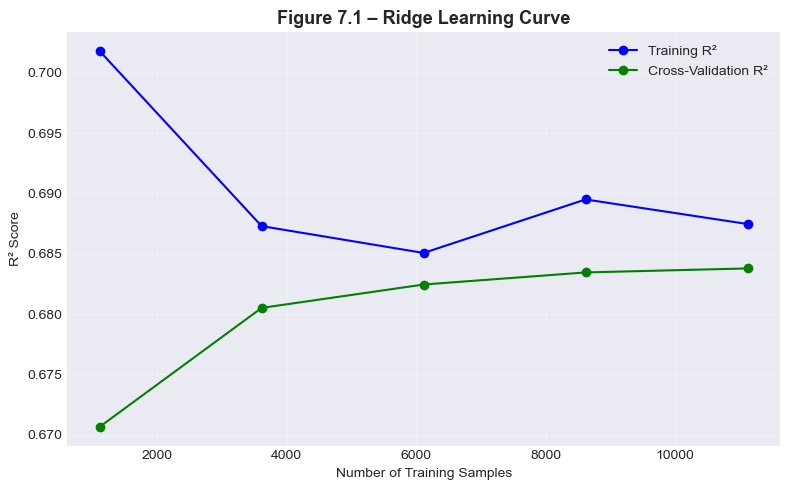

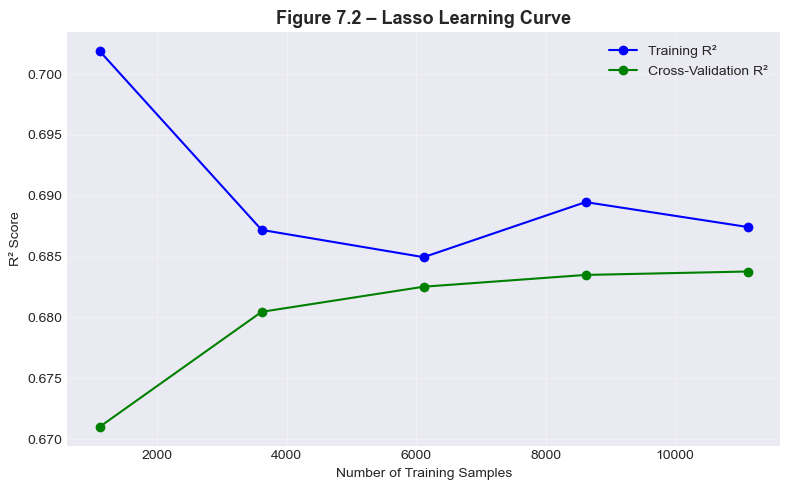

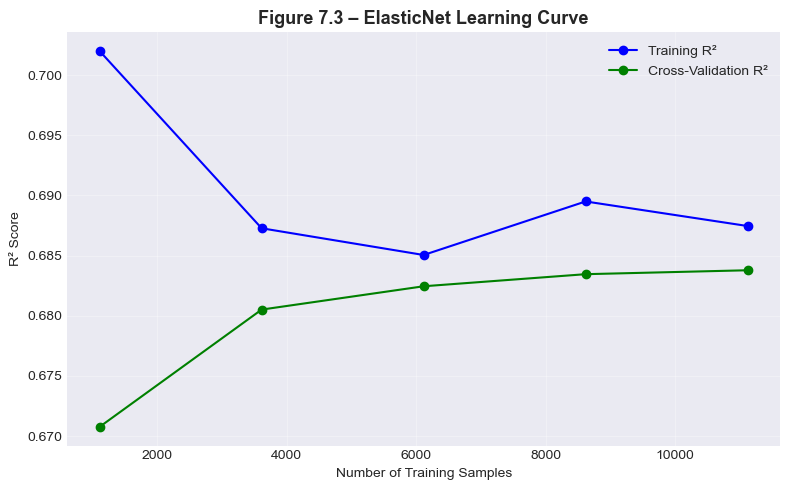

[OK] Learning Curves exported.


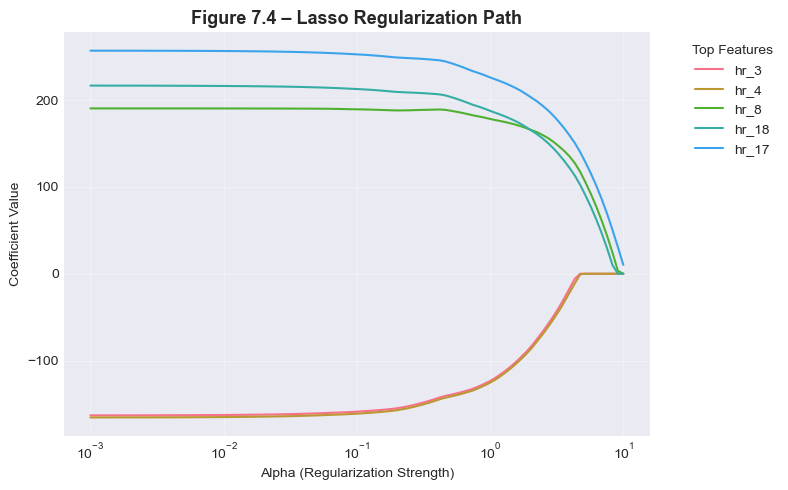

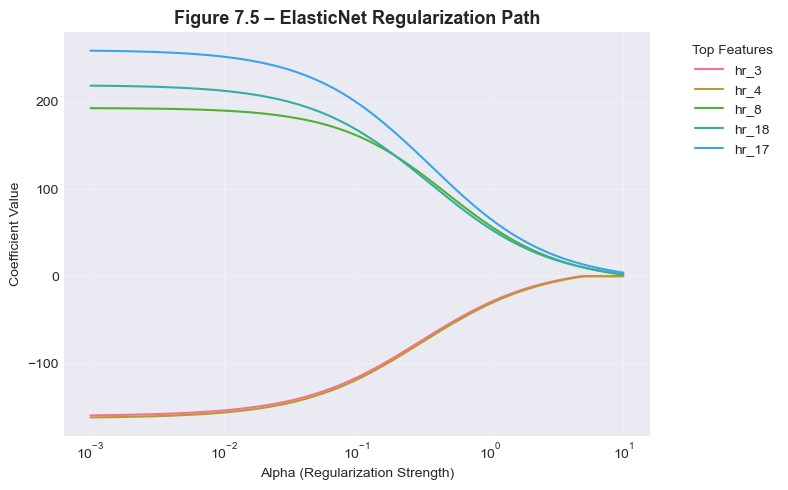

[OK] Regularization Paths exported.


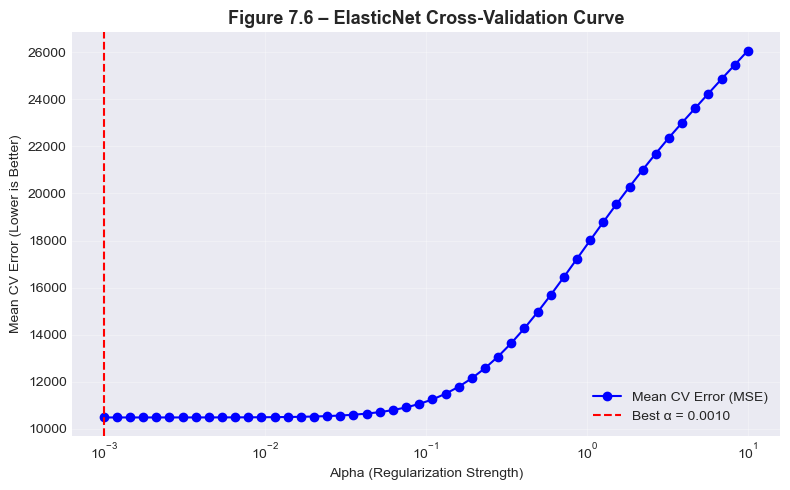

[OK] CV Curve exported.


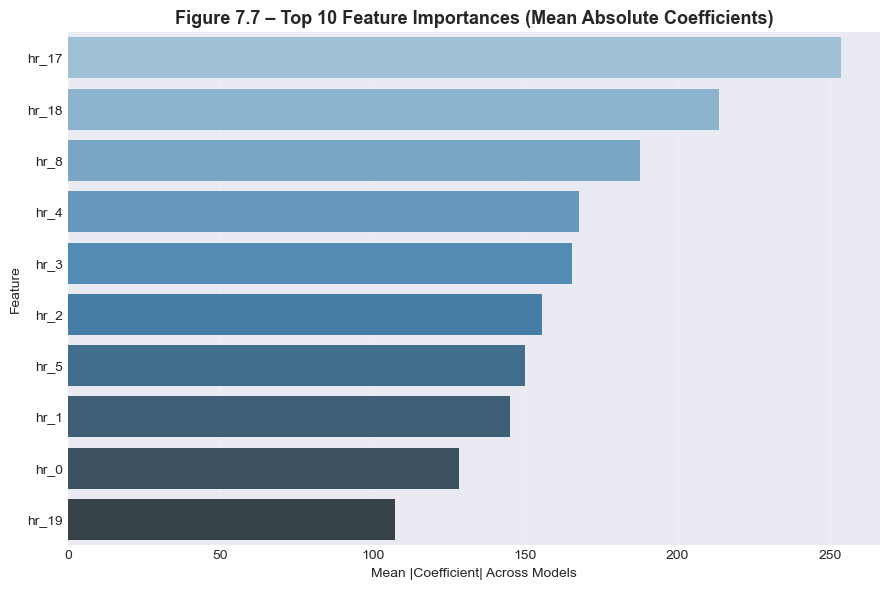

[OK] Feature Importance exported.


In [ ]:
# Create directory for appendix figures
# Ensures all figures have a dedicated folder for export
os.makedirs("results/appendix_figures", exist_ok=True)
print("[OK] Folder 'results/appendix_figures' ready for figure exports.")
# Suppress ConvergenceWarnings to keep notebook output clean
# These warnings appear when Lasso/ElasticNet solver does not fully converge within max_iter.
# The model coefficients and results are still valid.
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# =======================================================
# Learning Curves
# =======================================================
def plot_learning_curve(estimator, X, y, title, filename):
    """
    Plots and saves learning curves to show how model performance changes
    as the training dataset size increases (bias-variance analysis).
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', label='Training R²')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='green', label='Cross-Validation R²')
    plt.title(title, fontsize=13, fontweight='bold')
    plt.xlabel("Number of Training Samples")
    plt.ylabel("R² Score")
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"results/appendix_figures/{filename}.png", dpi=300, bbox_inches="tight")  # Save figure for appendix
    plt.show()

# Generate learning curves for all models
plot_learning_curve(ridge_cv, X_train, y_train, "Figure 7.1 – Ridge Learning Curve", "fig_7_1_ridge_learning_curve")
plot_learning_curve(lasso_cv, X_train, y_train, "Figure 7.2 – Lasso Learning Curve", "fig_7_2_lasso_learning_curve")
plot_learning_curve(elastic_cv, X_train, y_train, "Figure 7.3 – ElasticNet Learning Curve", "fig_7_3_elasticnet_learning_curve")

print("[OK] Learning Curves exported.")

# =======================================================
# Regularization Paths
# =======================================================
def plot_reg_path(model_type, filename, l1_ratio=None, figure_number=None):
    """
    Plots and saves the regularization path showing how model coefficients
    change with the regularization strength (alpha).
    Highlights the top 5 most influential features.
    """
    # Compute regularization path
    if model_type == 'Lasso':
        alphas, coefs, _ = lasso_path(X_train, y_train, alphas=np.logspace(-3, 1, 100))
    else:
        alphas, coefs, _ = enet_path(X_train, y_train, l1_ratio=l1_ratio, alphas=np.logspace(-3, 1, 100))

    # Identify top 5 most influential features
    mean_abs = np.mean(np.abs(coefs), axis=1)
    top_idx = np.argsort(mean_abs)[-5:]

    # Plot coefficients
    plt.figure(figsize=(8,5))  # gleiche Größe wie bei Learning Curves
    for i in top_idx:
        plt.plot(alphas, coefs[i, :], label=X_train.columns[i])
    plt.xscale("log")
    plt.xlabel("Alpha (Regularization Strength)")
    plt.ylabel("Coefficient Value")
    title_text = f"Figure {figure_number} – {model_type} Regularization Path" if figure_number else f"{model_type} Regularization Path – Top Feature Coefficients"
    plt.title(title_text, fontsize=13, fontweight='bold')
    plt.legend(title="Top Features", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"results/appendix_figures/{filename}.png", dpi=300, bbox_inches="tight")
    plt.show()

# Generate regularization paths
plot_reg_path("Lasso", "fig_7_4_lasso_reg_path", figure_number="7.4")
plot_reg_path("ElasticNet", "fig_7_5_elasticnet_reg_path", l1_ratio=elastic_cv.l1_ratio_, figure_number="7.5")

print("[OK] Regularization Paths exported.")

# =======================================================
# Cross-Validation Curve (ElasticNet)
# =======================================================
# Plot mean CV error vs alpha for ElasticNet to visualize optimal regularization
plt.figure(figsize=(8,5))
mse_enet_mean = np.mean(elastic_cv.mse_path_[np.where(elastic_cv.l1_ratio == elastic_cv.l1_ratio_)[0][0], :, :], axis=1)
plt.plot(elastic_cv.alphas_, mse_enet_mean, marker='o', color='blue', label='Mean CV Error (MSE)')
plt.axvline(elastic_cv.alpha_, color='red', linestyle='--', label=f'Best α = {elastic_cv.alpha_:.4f}')
plt.xscale('log')
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean CV Error (Lower is Better)")
plt.title("Figure 7.6 – ElasticNet Cross-Validation Curve", fontsize=13, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("results/appendix_figures/fig_7_6_elasticnet_cv_curve.png", dpi=300, bbox_inches="tight")
plt.show()

print("[OK] CV Curve exported.")

# =======================================================
# Feature Importance
# =======================================================
# Compare coefficients across all models to determine which features are most relevant
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Ridge": ridge_cv.coef_,
    "Lasso": lasso_cv.coef_,
    "ElasticNet": elastic_cv.coef_
})
coef_df["MeanAbs"] = coef_df[["Ridge", "Lasso", "ElasticNet"]].abs().mean(axis=1)
top_features = coef_df.sort_values("MeanAbs", ascending=False).head(10)

plt.figure(figsize=(9,6))
sns.barplot(
    y="Feature",
    x="MeanAbs",
    data=top_features,
    hue="Feature",    # fixes FutureWarning
    dodge=False,
    palette="Blues_d",
    legend=False
)
plt.title("Figure 7.7 – Top 10 Feature Importances (Mean Absolute Coefficients)", fontsize=13, fontweight='bold')
plt.xlabel("Mean |Coefficient| Across Models")
plt.ylabel("Feature")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig("results/appendix_figures/fig_7_7_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

print("[OK] Feature Importance exported.")

# 8. STATISTICAL TESTING

In [ ]:
cv_folds = 5  # Number of folds for cross-validation (consistent with Chapter 5)

# ----------------------------------------------------------------------------------
# STEP 1: Collect cross-validation (CV) scores for each model
# ----------------------------------------------------------------------------------
# These scores are required to compare model performance statistically.

# Baseline: Ordinary Least Squares (OLS) regression
scores_baseline = cross_val_score(LinearRegression(), X_train, y_train, cv=cv_folds, scoring='r2')  # R² scores over folds

# Ridge regression using the optimal alpha found in Chapter 5
scores_ridge = cross_val_score(Ridge(alpha=ridge_cv.alpha_), X_train, y_train, cv=cv_folds, scoring='r2')  # Regularized model

# Lasso regression using the optimal alpha found in Chapter 5
scores_lasso = cross_val_score(Lasso(alpha=lasso_cv.alpha_), X_train, y_train, cv=cv_folds, scoring='r2')  # Feature selection effect

# ElasticNet using the optimal alpha and l1_ratio found in Chapter 5
scores_elastic = cross_val_score(
    ElasticNet(alpha=elastic_cv.alpha_, l1_ratio=elastic_cv.l1_ratio_),
    X_train, y_train, cv=cv_folds, scoring='r2'
)  # Combined L1 and L2 regularization

# ----------------------------------------------------------------------------------
# STEP 2: Pairwise statistical tests (compare OLS vs regularized models)
# ----------------------------------------------------------------------------------

# A. Wilcoxon Signed-Rank Test (non-parametric); does not assume normal distribution of differences.
# 'alternative="less"' tests whether the regularized model scores are higher than baseline.
w_ridge, p_w_ridge = stats.wilcoxon(scores_baseline, scores_ridge, alternative='less')
w_lasso, p_w_lasso = stats.wilcoxon(scores_baseline, scores_lasso, alternative='less')
w_elastic, p_w_elastic = stats.wilcoxon(scores_baseline, scores_elastic, alternative='less')

# B. Paired t-Test (parametric, as reference)
# Checks if the mean difference of CV scores is significantly different from zero.
t_ridge, p_ridge = stats.ttest_rel(scores_baseline, scores_ridge)
t_lasso, p_lasso = stats.ttest_rel(scores_baseline, scores_lasso)
t_elastic, p_elastic = stats.ttest_rel(scores_baseline, scores_elastic)

# ----------------------------------------------------------------------------------
# STEP 3: Display results
# ----------------------------------------------------------------------------------

print("==========================================================")
print("Statistical Comparison (Wilcoxon & t-Test)")
print("==========================================================")
print(f"Baseline (OLS) mean R² over {cv_folds} folds: {np.mean(scores_baseline):.4f}\n")  # Summary of baseline performance

# Create a summary table for all model comparisons
data = {
    'Model Pair': ['OLS vs Ridge', 'OLS vs Lasso', 'OLS vs ElasticNet'],
    'Wilcoxon W': [w_ridge, w_lasso, w_elastic],               # Test statistic
    'Wilcoxon p-value': [p_w_ridge, p_w_lasso, p_w_elastic],  # Significance of Wilcoxon test
    't-Test t-stat': [t_ridge, t_lasso, t_elastic],           # Paired t-test statistic
    't-Test p-value': [p_ridge, p_lasso, p_elastic]           # Significance of paired t-test
}
results_df = pd.DataFrame(data)

# Format p-values for readability
results_df['Wilcoxon p-value'] = results_df['Wilcoxon p-value'].apply(lambda x: f'{x:.4e}' if x < 0.001 else f'{x:.4f}')
results_df['t-Test p-value'] = results_df['t-Test p-value'].apply(lambda x: f'{x:.4e}' if x < 0.001 else f'{x:.4f}')

# Display the results table
print(results_df.to_string(index=False))

print("\nInterpretation:")
print("A p-value < 0.05 indicates that the regularized model performs statistically significantly better than the OLS baseline.")  # Guidance for interpretation

# Optional: mean R² scores per model for quick reference
mean_scores = pd.DataFrame({
    'Model': ['OLS', 'Ridge', 'Lasso', 'ElasticNet'],
    'Mean R² (CV)': [np.mean(scores_baseline), np.mean(scores_ridge), np.mean(scores_lasso), np.mean(scores_elastic)]
})
print("\nMean R² scores per model:")  # Quick reference of overall performance
print(mean_scores.to_string(index=False, float_format='%.4f'))

# Suppress ConvergenceWarnings
# These warnings indicate that the solver did not fully converge within the specified number of iterations.
# In practice, the model coefficients and predictions are still valid, and the warnings mainly clutter notebook output.
# Suppressing them improves readability without affecting results.
warnings.filterwarnings("ignore", category=ConvergenceWarning)



Statistical Comparison (Wilcoxon & t-Test)
Baseline (OLS) mean R² over 5 folds: 0.6838

       Model Pair  Wilcoxon W Wilcoxon p-value  t-Test t-stat t-Test p-value
     OLS vs Ridge         7.0           0.5000      -0.267264         0.8025
     OLS vs Lasso         7.0           0.5000      -0.127628         0.9046
OLS vs ElasticNet         7.0           0.5000      -0.183036         0.8637

Interpretation:
A p-value < 0.05 indicates that the regularized model performs statistically significantly better than the OLS baseline.

Mean R² scores per model:
     Model  Mean R² (CV)
       OLS        0.6838
     Ridge        0.6838
     Lasso        0.6838
ElasticNet        0.6838


# 9. RESULTS EXPORT

In [ ]:
# 9.1 EXPORT OF MAIN RESULTS
# -----------------------------
# Create a folder for results if it does not exist
os.makedirs("results", exist_ok=True)

# Export key result tables: statistical test outcomes and mean R² scores
# These tables will be used to summarize model performance and comparison
results_df.to_csv("results/statistical_tests.csv", index=False)
mean_scores.to_csv("results/mean_r2_scores.csv", index=False)

print("[OK] Main result tables saved in the 'results' directory.")
print("[OK] Statistical test results and mean R² scores exported successfully.")

# -----------------------------
# 9.2 DATASET CHARACTERISTICS TABLE (APPENDIX)
# -----------------------------
# Calculate the total number of original features (including the target variable)
original_features_count = df.shape[1]

# Build a dictionary to summarize dataset characteristics
# Some values are dynamically calculated from the DataFrame, others are taken directly from the dataset description
dataset_info = {
    "Feature": [
        "Source",
        "Observations",
        "Period",
        "Original Features",
        "Encoded Features",
        "Target Variable",
        "Missing Values",
        "Train/Test Split"
    ],
    "Value": [
        "UCI Machine Learning Repository (Fanaee-T, 2013)",               # Dataset source
        f"{df.shape[0]:,} observations",                                 # Total number of rows
        "2011–2012",                                                      # Time period of data collection
        f"{original_features_count} (calculated from DataFrame)",         # Total columns including target
        f"{X_processed.shape[1]} (after One-Hot Encoding)",               # Number of features after preprocessing
        f"cnt (Bike Rentals, range: {df['cnt'].min()}–{df['cnt'].max()})", # Target variable and its observed range
        f"{df.isnull().sum().sum()} missing values",                      # Total missing values in the dataset
        f"80/20 ({X_train.shape[0]:,} / {X_test.shape[0]:,})"            # Train/Test split sizes
    ]
}

# Convert the dictionary to a DataFrame for display and export
dataset_df = pd.DataFrame(dataset_info)
display(dataset_df)  # Nicely formatted table for the notebook

# Create folder for appendix tables if it does not exist
os.makedirs("results/appendix_tables", exist_ok=True)

# Export dataset characteristics for inclusion in the paper appendix
dataset_df.to_csv("results/appendix_tables/dataset_characteristics.csv", index=False)
print("[OK] Dataset characteristics table exported to 'results/appendix_tables/'.")

# -----------------------------
# 9.3 APPENDIX TABLES: MODEL PERFORMANCE AND STATISTICAL TESTS
# -----------------------------
# Export previously computed statistical test results for appendix
results_df.to_csv("results/appendix_tables/statistical_tests_appendix.csv", index=False)
print("[OK] Statistical test results exported to 'results/appendix_tables/'.")

print("[DONE] All appendix exports completed successfully.")


[OK] Main result tables saved in the 'results' directory.
[OK] Statistical test results and mean R² scores exported successfully.


,Feature,Value
0,Source,"UCI Machine Learning Repository (Fanaee-T, 2013)"
1,Observations,"17,379 observations"
2,Period,2011–2012
3,Original Features,17 (calculated from DataFrame)
4,Encoded Features,61 (after One-Hot Encoding)
5,Target Variable,"cnt (Bike Rentals, range: 1–977)"
6,Missing Values,0 missing values
7,Train/Test Split,"80/20 (13,903 / 3,476)"


[OK] Dataset characteristics table exported to 'results/appendix_tables/'.
[OK] Statistical test results exported to 'results/appendix_tables/'.
[DONE] All appendix exports completed successfully.


In [ ]:
import subprocess, sys, os

# Path for the requirements file
req_path = "Notebooks/requirements.txt"

# Create folder if it doesn't exist
os.makedirs("Notebooks", exist_ok=True)

# Run pip freeze and write output to the file
result = subprocess.run(
    [sys.executable, "-m", "pip", "freeze"],
    capture_output=True,
    text=True,
    check=True
)
with open(req_path, "w", encoding="utf-8") as f:
    f.write(result.stdout)

print(f"[OK] requirements exported to '{req_path}'.")
# This code part was generated with the help of ChatGPT to ensure all required packages are documented


[OK] requirements exported to 'Notebooks/requirements.txt'.
